In [1]:
import math
import time
import matplotlib.pyplot as plt
import torch
import trimesh

from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)

import torch
import torch.nn.functional as F
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.io import load_obj
from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)
from pytorch3d.renderer.blending import BlendParams
from pytorch3d.renderer import TexturesVertex
from src.render.points_renderer import PointsRenderer
from src.config import get_parser
from src.blueprint_sampler import BlueprintSampler
from src.util import grid_to_list
torch.set_printoptions(sci_mode=False
)

import pytorch3d.transforms as T3

In [2]:
import numpy as np

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix


In [70]:
# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

bs = 1
    
config = get_parser().parse_args(args=[])

config.raster_image_size = 512
config.raster_radius = 0.012
config.raster_points_per_pixel = 4
    
d_size = 1024
config.data_blueprint = f'blueprint_radial_{d_size}.npz'
config.data_blueprint_size = d_size
config.data_patch_size = d_size // 5
config.raster_max_brightness = 0.9
#parser.add_argument('--raster_blur_radius', type=float, default=0.01)
#parser.add_argument('--raster_faces_per_pixel', type=int, default=4)

blueprintSampler = BlueprintSampler(config)
res = blueprintSampler(bs)
points = res['points']
normals = res['normals']
faces = res['faces']

points = grid_to_list(points).to(device)
normals = grid_to_list(normals).to(device)
#faces = faces.to(device)

points.shape, normals.shape, faces.shape

(torch.Size([1, 41616, 3]),
 torch.Size([1, 41616, 3]),
 torch.Size([1, 82418, 3]))

In [55]:
config.raster_blur_radius = 0.0
config.raster_faces_per_pixel = 4
R = PointsRenderer(config)
R.setup(device)
R = R.to(device)

torch.Size([1, 512, 512, 3])


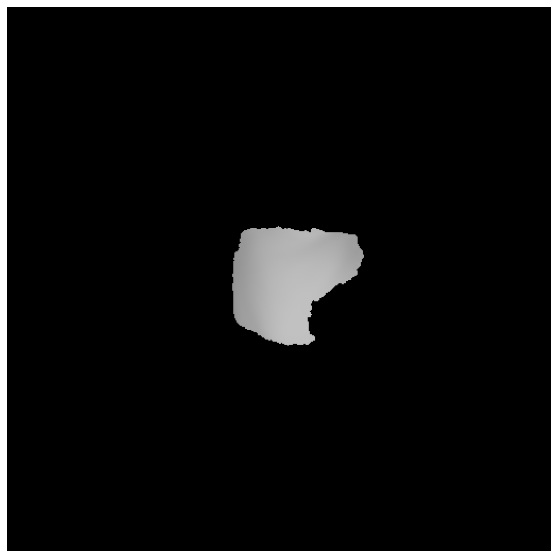

In [71]:
images = R(points, normals)
print(images.shape)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

[-0.6897078156471252, 0.04744996130466461, 0.7225314378738403]
tensor([-0.9967,  0.0686,  0.0441])
torch.Size([1, 512, 512, 3])


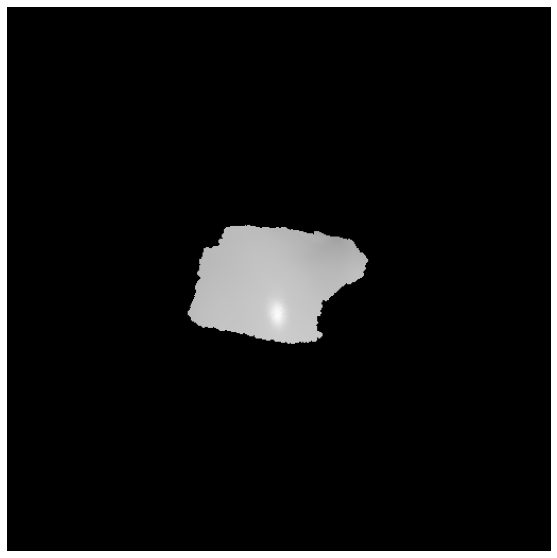

In [72]:
vec1 = F.normalize(normals.mean(dim=1), dim=-1)[0].cpu().tolist()#.shape
print(vec1)
#[-0.007786958944052458, -0.14118683338165283, 0.9899523258209229]
vec2 = [0., 0., 1.]
rot_mat = rotation_matrix_from_vectors(vec2, vec1)
rot_mat = torch.tensor(rot_mat).float()
print(rot_mat.mv(torch.tensor(vec1).float()))

RT  = T3.Rotate(rot_mat, device=points.device)

t_points = RT.transform_points(points)
t_normals = RT.transform_normals(normals)
images = R(t_points,t_normals)
print(images.shape)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");